In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import xgboost as xgb

In [5]:
df = pd.read_csv("train.csv", index_col='id')
test = pd.read_csv("test.csv", index_col='id')

categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
numerical_features = df.select_dtypes(include=['number']).columns

In [6]:
# fix seed

def seed_everything(seed=0):
    #random.seed(seed)
    #os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 42
seed_everything(SEED)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [8]:
#정규화 X 범주형 데이터 변환 X

# 범주형 변수를 'category' 타입으로 변환
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
df[categorical_features] = df[categorical_features].astype('category')

# XGBoost 모델 훈련 시 enable_categorical=True 설정
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Gradient Boosting

In [9]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss', enable_categorical=True, random_state=55)
xgb_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = xgb_model.predict(X_test)
print("F1-score (XGBoost):", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

F1-score (XGBoost): 0.8135411069317571
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12613
           1       0.90      0.74      0.81      2049

    accuracy                           0.95     14662
   macro avg       0.93      0.86      0.89     14662
weighted avg       0.95      0.95      0.95     14662



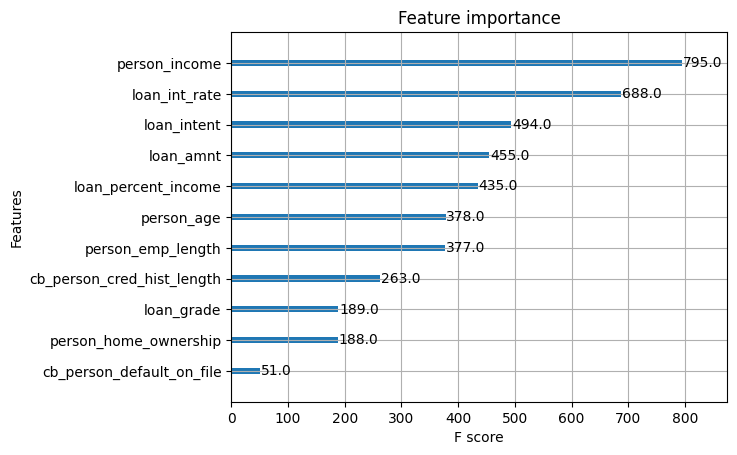

In [10]:
from xgboost import plot_importance

# 특성 중요도 시각화
plot_importance(xgb_model)
plt.show()

In [21]:
from catboost import CatBoostClassifier

# CatBoost 모델 생성 및 학습
catboost_model = CatBoostClassifier(logging_level='Silent', cat_features=categorical_features, random_state=55)
catboost_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = catboost_model.predict(X_test)
print("F1-score (CatBoost):", f1_score(y_test, y_pred))

Learning rate set to 0.051834
0:	learn: 0.6289605	total: 61.9ms	remaining: 1m 1s
100:	learn: 0.1656981	total: 6.29s	remaining: 56s
200:	learn: 0.1561397	total: 13.2s	remaining: 52.4s
300:	learn: 0.1482059	total: 21.9s	remaining: 50.9s
400:	learn: 0.1416430	total: 28.3s	remaining: 42.2s
500:	learn: 0.1370259	total: 36.9s	remaining: 36.7s
600:	learn: 0.1331980	total: 44.6s	remaining: 29.6s
700:	learn: 0.1298685	total: 51s	remaining: 21.8s
800:	learn: 0.1262742	total: 57.4s	remaining: 14.3s
900:	learn: 0.1227157	total: 1m 3s	remaining: 7.01s
999:	learn: 0.1198956	total: 1m 10s	remaining: 0us
F1-score (CatBoost): 0.8140540540540541


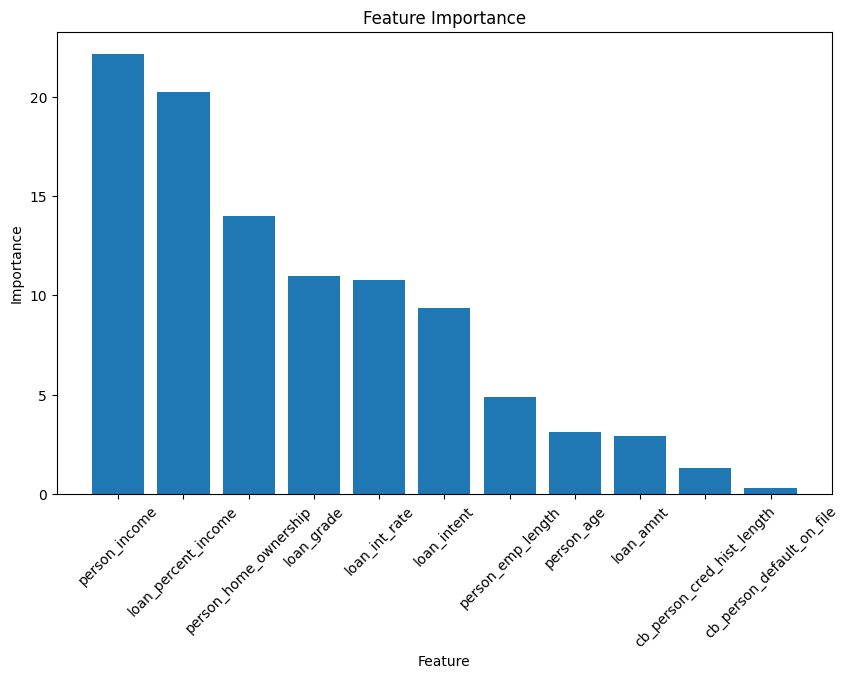

In [32]:
# 특성 중요도
feature_importance = catboost_model.get_feature_importance()

# 특성 이름
feature_names = X_train.columns

feature_importance, feature_names = zip(*sorted(zip(feature_importance, feature_names), reverse=True))

# matplotlib으로 막대 그래프 시각화
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importance)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

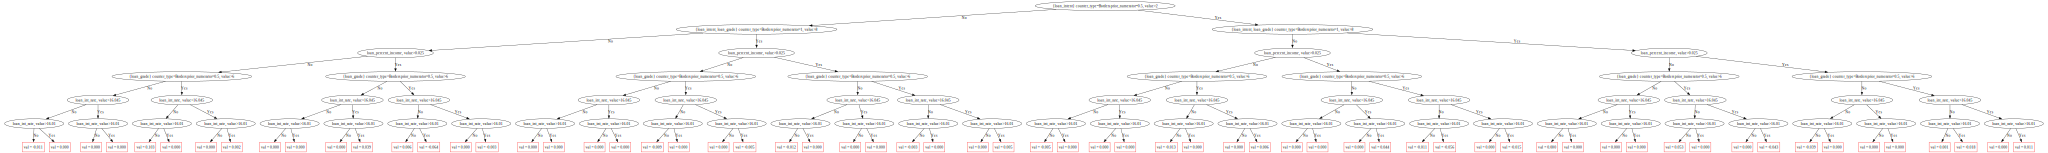

In [18]:
# 특성 중요도 시각화
from catboost import Pool

is_cat = (X_train_final.dtypes == 'category')
cat_features_index = np.where(is_cat)[0] 

# 트리 시각화
catboost_model.plot_tree(tree_idx=0, pool=Pool(X_train_final, y_train_final, cat_features=cat_features_index, feature_names=list(X_train_final.columns)))

다중공선성 문제는 없을까?

loan_percent_income -> loan과 income의 선형적 변수임 
-> 선형적 변수가 아니었음;;; 


F1-score (XGBoost): 0.8021333333333334
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     12613
           1       0.88      0.73      0.80      2049

    accuracy                           0.95     14662
   macro avg       0.92      0.86      0.89     14662
weighted avg       0.95      0.95      0.95     14662



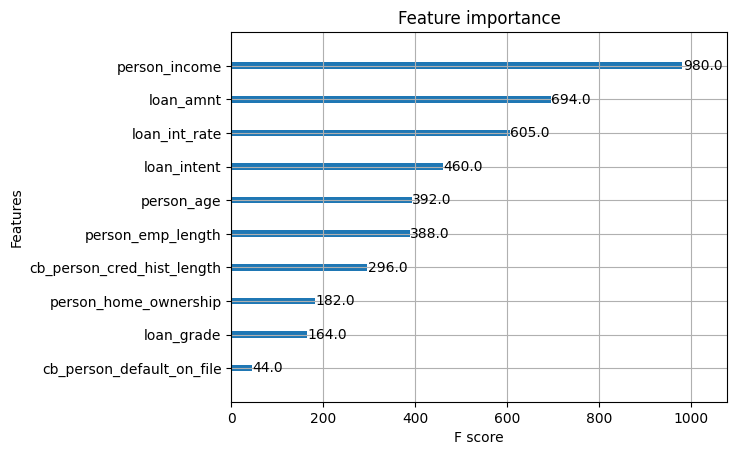

In [61]:
#xgboost
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
df[categorical_features] = df[categorical_features].astype('category')

# XGBoost 모델 훈련 시 enable_categorical=True 설정
X = df.drop(['loan_percent_income', 'loan_status'], axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

xgb_model = xgb.XGBClassifier(eval_metric='logloss', enable_categorical=True, random_state=SEED)
xgb_model.fit(X_train, y_train)

# 예측 및 평가
y_pred = xgb_model.predict(X_test)
print("F1-score (XGBoost):", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# 특성 중요도 시각화
plot_importance(xgb_model)
plt.show()


F1-score (CatBoost): 0.8119612068965517
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     12613
           1       0.91      0.74      0.81      2049

    accuracy                           0.95     14662
   macro avg       0.93      0.86      0.89     14662
weighted avg       0.95      0.95      0.95     14662



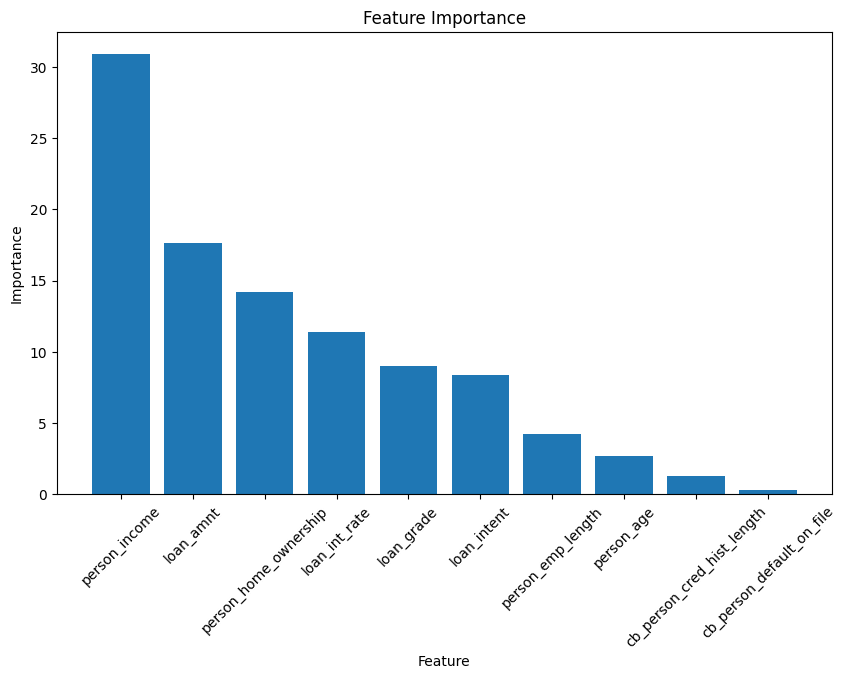

In [60]:
#Catboost에서 다중공선성 문제 확인
#정규화 X 범주형 데이터 변환 X

# 범주형 변수를 'category' 타입으로 변환
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
df[categorical_features] = df[categorical_features].astype('category')

# XGBoost 모델 훈련 시 enable_categorical=True 설정
X = df.drop(['loan_percent_income', 'loan_status'], axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

# CatBoost 모델 생성 및 학습
catboost_model_test_a1 = CatBoostClassifier(logging_level='Silent', cat_features=categorical_features, random_state=SEED)
catboost_model_test_a1.fit(X_train, y_train)

# 예측 및 평가
y_pred = catboost_model_test_a1.predict(X_test)
print("F1-score (CatBoost):", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
# 특성 중요도
feature_importance = catboost_model_test_a1.get_feature_importance()

# 특성 이름
feature_names = X_train.columns

feature_importance, feature_names = zip(*sorted(zip(feature_importance, feature_names), reverse=True))

# matplotlib으로 막대 그래프 시각화
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importance)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

loan_percent_income을 제거하면 오히려 income에 의존성이 올라가는 것으로 보인다 그래서 f1 score가 미미하게 감소하는 추세였다 

In [9]:
test_encoded = pd.get_dummies(test, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'])
test_encoded_scaled = scaler.fit_transform(test_encoded)